# analysis loss score

## modules

In [1]:
import pandas as pd
import pylab as plt
import numpy as np
import seaborn as sns
from util.databinder import DataBinder
from IPython.display import display, HTML

## variables, functions and classes

In [2]:
def load_json_from_file(f:str):
    with open(f, 'r') as fin:
        dict_data = json.load(fin)
    return dict_data

## parameters

In [3]:
dir_eval_result = './reports/20240815/evaluation_fb15k237_transe_try1'

## main

read results

In [4]:
db = DataBinder(dir_eval_result)
dict_eval_results = db.get('evaluation_results')

INFO:root:Loaded info from ./reports/20240815/evaluation_fb15k237_transe_try1/info.json


### hits@k

In [5]:
dict_df_hits = {}
for model_random_seed, dict_data in dict_eval_results.items():
    for data_radom_seed, _dict_data in dict_data.items():
        print(_dict_data['model_info'])
        dict_df_hits[model_random_seed] = pd.Series(_dict_data['model_info']['hits@k']).to_frame(name='hits@k').T
        break

{'hits@k': {1: 0.1922154809668265, 3: 0.28965652216459536, 5: 0.34002837851061746, 10: 0.41232018788531166}}
{'hits@k': {1: 0.19170173206771698, 3: 0.2895831294647226, 5: 0.34169194637440065, 10: 0.4115862608865838}}
{'hits@k': {1: 0.19018494960367943, 3: 0.2864027791369019, 5: 0.34041980624327234, 10: 0.4127605440845484}}
{'hits@k': {1: 0.18920638027204228, 3: 0.2867942068695567, 5: 0.33880516684607104, 10: 0.4114639397201292}}
{'hits@k': {1: 0.19150601820138957, 3: 0.2872834915353753, 5: 0.33907427341227125, 10: 0.40982483608963693}}


In [6]:
for model_random_seed, df_hits in dict_df_hits.items():
    display(f'Random seed = {model_random_seed}')
    display(df_hits)

'Random seed = 42'

,1,3,5,10
hits@k,0.192215,0.289657,0.340028,0.41232


'Random seed = 123'

,1,3,5,10
hits@k,0.191702,0.289583,0.341692,0.411586


'Random seed = 456'

,1,3,5,10
hits@k,0.190185,0.286403,0.34042,0.412761


'Random seed = 789'

,1,3,5,10
hits@k,0.189206,0.286794,0.338805,0.411464


'Random seed = 101112'

,1,3,5,10
hits@k,0.191506,0.287283,0.339074,0.409825


### true negative ratio

In [7]:
dict_df_tnr = {}
for model_ramdon_seed, dict_data in dict_eval_results.items():
    dict_df_tnr[model_ramdon_seed] = \
    pd.DataFrame({data_random_seed:{k:v['value'] for k,v in _dict_data['true_negative_ratio'].items()} for data_random_seed, _dict_data in dict_data.items()}).T

'Random seed = 42'

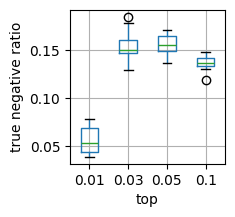

None

'Random seed = 123'

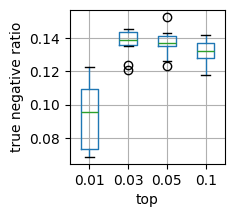

None

'Random seed = 456'

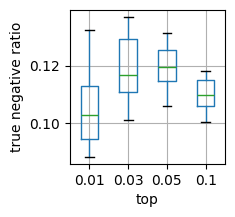

None

'Random seed = 789'

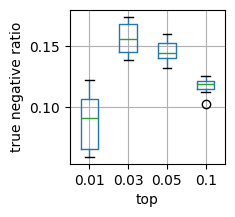

None

'Random seed = 101112'

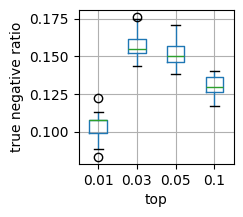

None

In [24]:
for model_random_seed, df_tnr in dict_df_tnr.items():
    display(f'Random seed = {model_random_seed}')
    fig, ax = plt.subplots(figsize=(2,2))
    df_tnr.boxplot(ax=ax)
    ax.set_xlabel('top')
    ax.set_ylabel('true negative ratio')
    display(plt.show())

### precision recall curve

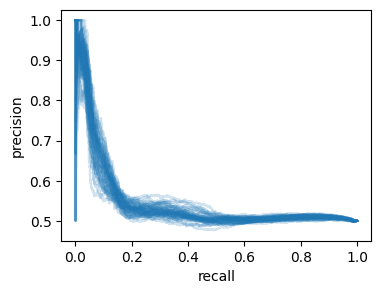

In [9]:
fig, ax = plt.subplots(figsize=(4,3))
for model_random_seed, dict_data in dict_eval_results.items():
    for datset_random_seed, _dict_data in dict_data.items():
        x = _dict_data['precision_recall_curve']['recall']
        y = _dict_data['precision_recall_curve']['precision']
        ax.plot(x,y, alpha=0.2, color='C0')
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')

### analysis
この分析ではRecallに着目する．
すなわち，本来誤りであるのにも関わらず検知されないトリプルに着目し，なぜそれが検知されない（スコアが大きい/小さくない）のか，トリプルの特徴に着目して分析する．

In [18]:
model_random_seed = list(dict_eval_results.keys())[1]
dataset_random_seet = list(dict_eval_results[model_ramdon_seed].keys())[1]
top = 0.1
df = dict_eval_results[model_ramdon_seed][datset_random_seed]['dataframe']
threshold = dict_eval_results[model_ramdon_seed][datset_random_seed]['true_negative_ratio'][top]['threshold']

In [19]:
dict_eval_results[model_ramdon_seed][datset_random_seed]['true_negative_ratio']

{0.01: {'value': 0.10784313725490197, 'threshold': -22.870102},
 0.03: {'value': 0.1533442088091354, 'threshold': -20.7571},
 0.05: {'value': 0.14593535749265427, 'threshold': -20.060198},
 0.1: {'value': 0.1346059716103769, 'threshold': -19.18504}}

In [20]:
dict_df = {}
dict_df['TP'] = df[(df['scores']>threshold)&(df['is-error']==False)]
dict_df['FP'] = df[(df['scores']>threshold)&(df['is-error']==True)]
dict_df['FN'] = df[(df['scores']<threshold)&(df['is-error']==False)]
dict_df['TN'] = df[(df['scores']<threshold)&(df['is-error']==True)]

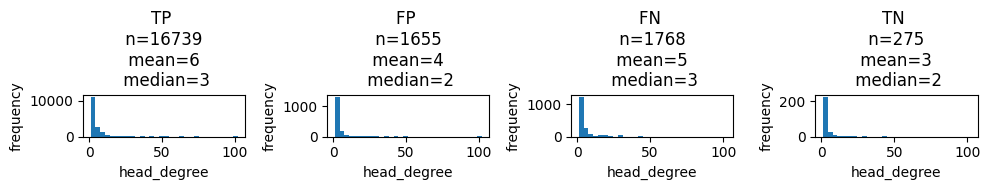

None

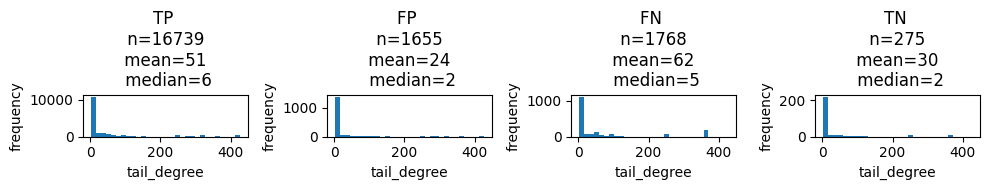

None

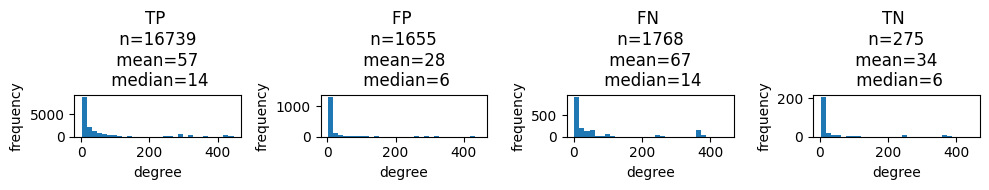

None

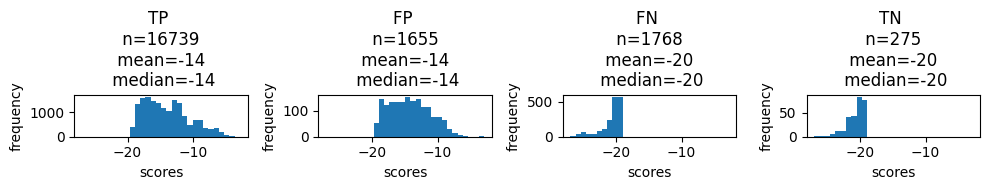

None

In [21]:
numeric_cols = ['head_degree', 'tail_degree', 'degree', 'scores']
n = len(dict_df)
for col in numeric_cols:

    display(HTML(f'<h3>{col}</h3>'))
    
    vmin = np.min([df[col].min() for df in dict_df.values()])
    vmax = np.max([df[col].max() for df in dict_df.values()])
    
    fig, axs = plt.subplots(ncols=n, sharex=True, figsize=(10,2))
    i = 0
    for _type, df in dict_df.items():
        axs[i].hist(df[col].values, label=_type, range=(vmin, vmax),bins=30)
        v = df[col].values
        axs[i].set_title(f'{_type} \n n={len(df)} \n mean={int(v.mean())} \n median={int(np.median(v))}')
        axs[i].set_xlabel(col)
        axs[i].set_ylabel('frequency')
        i += 1
    fig.tight_layout()
    display(plt.show())

In [22]:
nnodes = []
nrelations = []
for _type, df in dict_df.items():
    nnodes += list(df['head'].unique()) + list(df['tail'].unique())
    nrelations += list(df['relation'].unique())
nnodes = list(set(nnodes))
nrelations = list(set(nrelations))
map_nname_to_nid = {nname:nid for nid, nname in enumerate(nnodes)}
map_rname_to_rid = {rname:rid for rid, rname in enumerate(nrelations)}

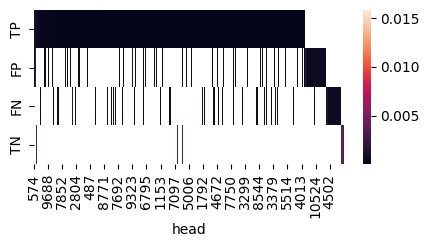

None

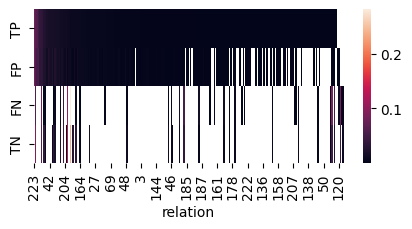

None

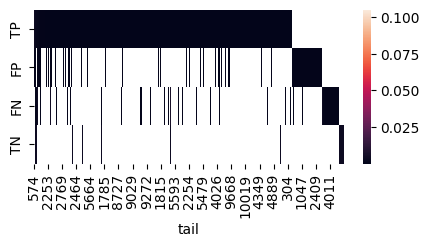

None

In [23]:
discrete_cols = ['head', 'relation', 'tail']
n = len(dict_df)
for col in discrete_cols:

    display(HTML(f'<h3>{col}</h3>'))
    list_sr_counts = []
    for _type, df in dict_df.items():
        _sr_counts = df[col].value_counts()
        sr_counts = _sr_counts/_sr_counts.sum()
        list_sr_counts.append(sr_counts)
    
    df_count = pd.DataFrame(list_sr_counts, index=list(dict_df.keys()))
    if col == 'relation':
        df_count.rename(columns=map_rname_to_rid, inplace=True)
    elif col == 'head' or col == 'tail':
        df_count.rename(columns=map_nname_to_nid, inplace=True)
    else:
        pass
        
    fig, ax = plt.subplots(figsize=(5,2))
    sns.heatmap(df_count, ax=ax)
    display(plt.show())

### analysis for degree

In [16]:
top = 0.05
dict_data  = {stat_type:{degree_type:[] for degree_type in ['head_degree', 'tail_degree', 'degree']} for stat_type in ['mean', 'median']}

for model_random_seed, _dict_eval_results in dict_eval_results.items():
    for datset_random_seed, dict_eval_result in _dict_eval_results.items():
        
        df = dict_eval_results[model_ramdon_seed][datset_random_seed]['dataframe']
        threshold = dict_eval_results[model_ramdon_seed][datset_random_seed]['true_negative_ratio'][top]['threshold']

        dict_df = {}
        dict_df['TP'] = df[(df['scores']>threshold)&(df['is-error']==False)]
        dict_df['FP'] = df[(df['scores']>threshold)&(df['is-error']==True)]
        dict_df['FN'] = df[(df['scores']<threshold)&(df['is-error']==False)]
        dict_df['TN'] = df[(df['scores']<threshold)&(df['is-error']==True)]

        for stat_type in dict_data.keys():
            for degree_type in dict_data[stat_type].keys():
                if stat_type == 'mean':
                    rd = {cat:df[degree_type].mean() for cat, df in dict_df.items()}
                elif stat_type == 'median':
                    rd = {cat:df[degree_type].median() for cat, df in dict_df.items()}
                else:
                    pass
                dict_data[stat_type][degree_type].append(rd)

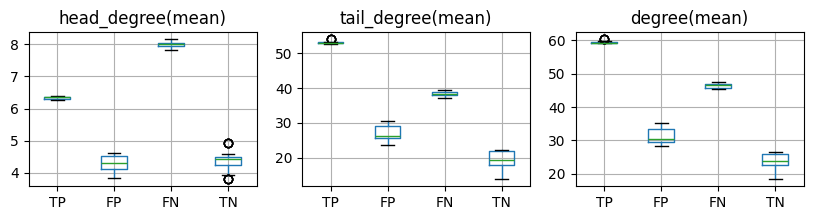

None

,TP,FP,FN,TN
head_degree,6.335338,4.283115,7.993787,4.359951
tail_degree,53.078337,26.792101,38.407938,19.266997
degree,59.413675,31.075216,46.401725,23.626947


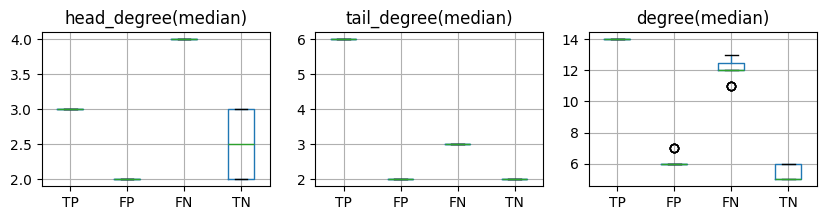

None

,TP,FP,FN,TN
head_degree,3.0,2.0,4.0,2.5
tail_degree,6.0,2.0,3.0,2.0
degree,14.0,6.1,12.1,5.3


In [17]:
for stat_type in dict_data.keys():
    display(HTML(f'<h3>{stat_type}</h3>'))
    fig, axs = plt.subplots(ncols=3, figsize=(10,2))
    list_sr_mean = []
    for i, degree_type in enumerate(dict_data[stat_type].keys()):
        axs[i].set_title(f'{degree_type}({stat_type})')
        df = pd.DataFrame(dict_data[stat_type][degree_type])
        df.boxplot(ax=axs[i])
        list_sr_mean.append(df.mean())
    display(plt.show())
    display(pd.DataFrame(list_sr_mean, index=list(dict_data[stat_type].keys())))